In [190]:
import numpy as np
import scipy.io as sio
import h5py
import tensorflow as tf
import pickle
import os
from matplotlib import pyplot as plt
import importlib
import inspect
from copy import deepcopy
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# root directory
if os.getcwd().find('/Users/svnh2') != -1:
    root_directory = '/Users/svnh2/Desktop/projects'
elif os.getcwd().find('/home/svnh') != -1:
    root_directory = '/mindhive/nklab/u/svnh'
elif os.getcwd().find('/home/svnh') != -1:
    root_directory = '/mindhive/nklab/u/svnh'
elif os.getcwd().find('/mindhive/nklab3') != -1:
    root_directory = '/mindhive/nklab/u/svnh'
else:
    raise NameError('No root directory found')
    
# external repositories that depend on the root directory
# reload, in case they've changed
import sys
sys.path.append(root_directory)
from general_analysis import misc

Import CNN code, reset the graph

In [269]:
import cnn
importlib.reload(cnn)
tf.reset_default_graph()

Create some random features for input to CNN

In [260]:
# features
n_feats = 20
n_stim = 100
n_tps_per_stim = 100
feat_dims = [n_stim, n_tps_per_stim, n_feats]
sr_Hz = 100
feat_dims = data_dims[0:2] + [n_feats]
F = np.random.randn(feat_dims[0], feat_dims[1], feat_dims[2])

Create a random 2-layer network and sample from it

In [261]:
# layer 1
layer = {}
layer['type'] = 'conv'
layer['time_win_sec'] = 0.1
layer['act'] = 'relu'
layer['n_kern'] = 2
layer['rank'] = 1
layers = []
layers.append(layer)

# layer 2
layer = {}
layer['type'] = 'reweight'
layer['time_win_sec'] = 0.1
layer['act'] = 'identity'
layer['n_kern'] = 10
layer['rank'] = None
layers.append(layer)

# create network
net1_seed = 1
n_resp = 10
data_dims = [n_stim, n_tps_per_stim, n_resp]
net1 = cnn.Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=net1_seed)
net1.build()
D = net1.predict(F)

Create a second network, and try to fit to the data from the first

In [262]:
# initialize second network
net2_seed = net1_seed+1
net2 = cnn.Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=net2_seed, weight_scale=0.001)
net2.build()

# train
n_train = np.int32(np.round(n_stim*0.6))
n_val = np.int32(np.round(n_stim*0.2))
n_test = n_stim - n_train - n_val
train_val_test = np.concatenate((np.zeros(n_train), np.ones(n_val), np.ones(n_test)*2), 0)
early_stopping_steps = 0 # 0 implies no early stopping
net2.train(F, D, max_iter=1000, eval_interval=30, learning_rate=0.01, 
           batch_size=10, train_val_test=train_val_test, 
           early_stopping_steps=early_stopping_steps)

30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870
900
930
960
990


Plots illustrating results

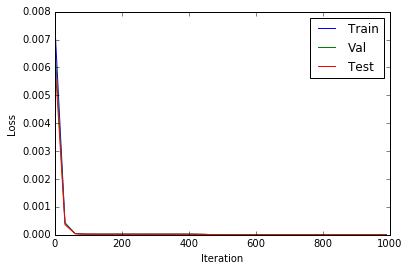

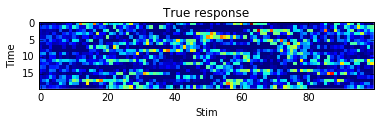

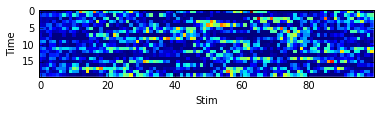

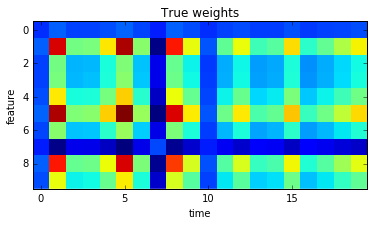

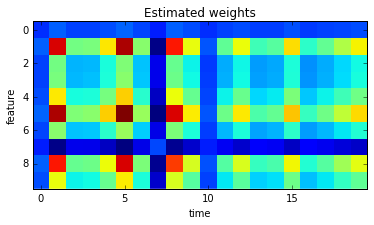

In [263]:
# loss
start_iter = 0
plt.plot(net2.iteration[start_iter:], net2.train_loss[start_iter:])
plt.plot(net2.iteration[start_iter:], net2.val_loss[start_iter:])
plt.plot(net2.iteration[start_iter:], net2.test_loss[start_iter:])
plt.legend(['Train', 'Val', 'Test'], loc='upper right')
plt.xlabel('Iteration'); plt.ylabel('Loss')
plt.show()

# true and estimated response (first response)
D_test = net1.predict(F[train_val_test==2,:,:])
plt.imshow(D_test[:,:,0], interpolation='none')
plt.title('True response')
plt.xlabel('Stim'); plt.ylabel('Time')
plt.show()
D_test_estimated = net2.predict(F[train_val_test==2,:,:])
plt.imshow(D_test_estimated[:,:,0], interpolation='none')
plt.xlabel('Stim'); plt.ylabel('Time')
plt.show('Estimated response')
plt.show()

# true and estimated weights (layer 1)
net1_layer_vals = net1.layer_vals()
net2_layer_vals = net2.layer_vals()
plt.imshow(net1_layer_vals[0]['W'][:,:,0], interpolation='none')
plt.xlabel('time'); plt.ylabel('feature')
plt.title('True weights')
plt.show()
plt.imshow(net2_layer_vals[0]['W'][:,:,0], interpolation='none')
plt.xlabel('time'); plt.ylabel('feature')
plt.title('Estimated weights')
plt.show()

Same as above, but with two features and two networks trained with different weights. Useful when you want to predict responses from two different feature sets. 

30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870
900
930
960
990


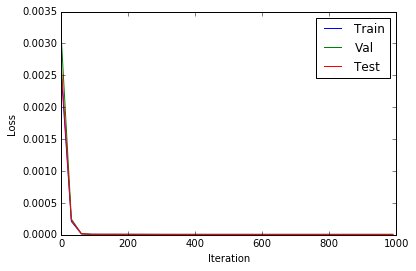

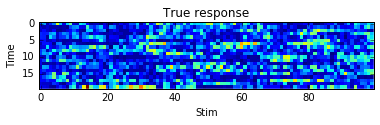

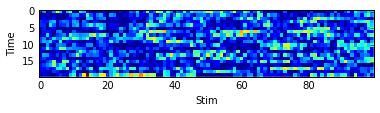

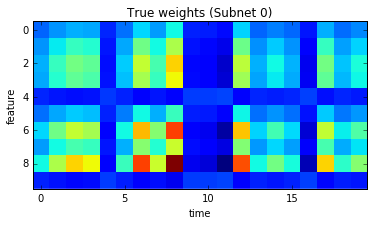

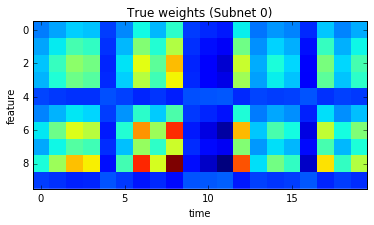

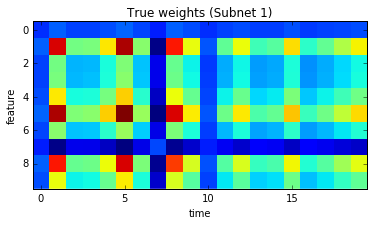

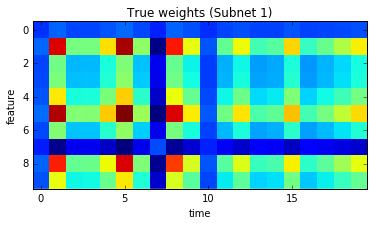

In [265]:
# two sets of features
F1 = np.random.randn(feat_dims[0], feat_dims[1], feat_dims[2])
F2 = np.random.randn(feat_dims[0], feat_dims[1], feat_dims[2])

# create features and data
net1_seed = 0
net1_1 = cnn.Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=net1_seed)
net1_2 = cnn.Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=net1_seed+1) 
multi_net1 = cnn.MultiNet([net1_1, net1_2])
multi_net1.build()
D = multi_net1.predict([F1, F2])

# new multi net
net2_seed = net1_seed + 10
net2_1 = cnn.Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=net2_seed, weight_scale=0.001)
net2_2 = cnn.Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=net2_seed+1, weight_scale=0.001)
multi_net2 = cnn.MultiNet([net2_1, net2_2])
multi_net2.build()

# train
n_train = np.int32(np.round(n_stim*0.6))
n_val = np.int32(np.round(n_stim*0.2))
n_test = n_stim - n_train - n_val
train_val_test = np.concatenate((np.zeros(n_train), np.ones(n_val), np.ones(n_test)*2), 0)
early_stopping_steps = 0 # 0 implies no early stopping
multi_net2.train([F1, F2], D, max_iter=1000, eval_interval=30, learning_rate=0.01, 
           batch_size=10, train_val_test=train_val_test, 
           early_stopping_steps=early_stopping_steps)

# loss
start_iter = 0
plt.plot(multi_net2.iteration[start_iter:], multi_net2.train_loss[start_iter:])
plt.plot(multi_net2.iteration[start_iter:], multi_net2.val_loss[start_iter:])
plt.plot(multi_net2.iteration[start_iter:], multi_net2.test_loss[start_iter:])
plt.legend(['Train', 'Val', 'Test'], loc='upper right')
plt.xlabel('Iteration'); plt.ylabel('Loss')
plt.show()

# true and estimated response (first response)
F_test = [F1[train_val_test==2,:,:], F2[train_val_test==2,:,:]]
D_test = multi_net1.predict(F_test)
plt.imshow(D_test[:,:,0], interpolation='none')
plt.title('True response')
plt.xlabel('Stim'); plt.ylabel('Time')
plt.show()
D_test_estimated = multi_net2.predict(F_test)
plt.imshow(D_test_estimated[:,:,0], interpolation='none')
plt.xlabel('Stim'); plt.ylabel('Time')
plt.show('Estimated response')
plt.show()

# true and estimated weights (first layer)
for i in range(2):
    multi_net1_layer_vals = multi_net1.layer_vals()
    multi_net2_layer_vals = multi_net2.layer_vals()
    plt.imshow(multi_net1_layer_vals[i][0]['W'][:,:,0], interpolation='none')
    plt.xlabel('time'); plt.ylabel('feature')
    plt.title('True weights (Subnet ' + str(i) + ')')
    plt.show()
    plt.imshow(multi_net2_layer_vals[i][0]['W'][:,:,0], interpolation='none')
    plt.xlabel('time'); plt.ylabel('feature')
    plt.title('True weights (Subnet ' + str(i) + ')')
    plt.show()

END OF WELL DOCUMENTED SECTION

In [ ]:
X_basis = np.randn

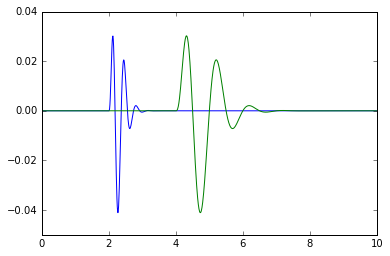

In [556]:
def gammatone(sr, win, shift, scale, rel_shift, rel_scale):

    N = np.int32(np.round(sr * win))
    x = np.linspace(0, 1-1/N, N)*win
    z1 = (x - rel_shift) * np.exp(rel_scale)
    z2 = (z1 - shift) * np.exp(scale)
    z3 = np.maximum(z2,0)
    f = (z3**2) * np.exp(-3.5*z3) * np.sin(2*np.pi*z3)
    
    return {'f': f, 'x': x}

def mexhat(sr, win, shift, scale, rel_shift, rel_scale):

    N = np.int32(np.round(sr * win))
    x = np.linspace(-1, 1, N)*(0.5*(N-1)/N)*win
    z1 = (x - rel_shift) * np.exp(rel_scale)
    z2 = (z1 - shift) * np.exp(scale)
    f = (1 - 2 * (np.pi * z2)**2) * np.exp(-(np.pi * z2)**2)
    
    return {'f': f, 'x': x}

sr = 100
win = 10
rel_shift = 2
rel_scale = 0
scale = 1
shift = 0
fx1 = gammatone(sr, win, shift, scale, rel_shift, rel_scale)
scale = 0
shift = 2
fx2 = gammatone(sr, win, shift, scale, rel_shift, rel_scale)

plt.plot(fx1['x'], fx1['f'])
plt.plot(fx2['x'], fx2['f'])
# plt.plot(fx2['x'], fx1['f'] + fx2['f'])

In [548]:
# layer 1
layer = {}
layer['type'] = 'conv'
layer['time_win_sec'] = 0.1
layer['act'] = 'relu'
layer['n_kern'] = 2
layer['rank'] = None
layers = []
layers.append(layer)

# layer 2
layer = {}
layer['type'] = 'reweight'
layer['time_win_sec'] = 0.1
layer['act'] = 'identity'
layer['n_kern'] = 10
layer['rank'] = None
layers.append(layer)

# create features and data
data_dims = [50, 50, 10] # stim x time x n_resp
n_feats = 5
sr_Hz = 100
T1 = Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=100)
T2 = Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=101) 
Tm = MultiNet([T1, T2])
Tm.build()
feat_dims = data_dims[0:2] + [n_feats]
F1 = np.random.randn(feat_dims[0], feat_dims[1], feat_dims[2])
F2 = np.random.randn(feat_dims[0], feat_dims[1], feat_dims[2])
D = Tm.predict([F1, F2])

In [615]:
(0**2) * np.exp(-3.5*0) * np.sin(2*np.pi*0)

0.0

In [557]:
def scale_bases(sr, win, fn, n_bases, scales, rel_scales):

    n_trans = len(rel_scales)
    N = np.int32(win*sr)
    shifts = np.zeros(scales.shape)
    rel_shifts = np.zeros(rel_scales.shape)
    A = np.zeros((N, n_trans, n_bases))
    for i in range(n_trans):
        for j in range(n_bases):
            if i == 1 and j == 1:
                x = fn([sr, win, shifts[j], scales[j], rel_shifts[i], rel_scales[i]])['x']
            A[:,i,j] = fn([sr, win, shifts[j], scales[j], rel_shifts[i], rel_scales[i]])['f']
    
    return A

def apply_weights(A, w):
        
    Ar = np.reshape(A, [A.shape[0]*A.shape[1], A.shape[2]])
    Ar_w = np.matmul(Ar, w)
    A_w = np.reshape(Ar_w, [A.shape[0], A.shape[1], w.shape[1]])
    
    return(A_w)

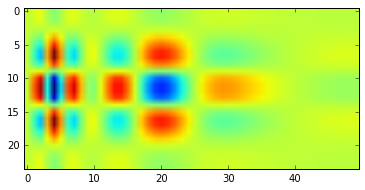

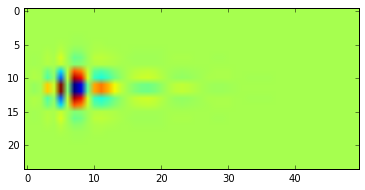

In [561]:
separable = True
n_bases = 1000

temp = {}
temp['sr_Hz'] = 100
temp['win_sec'] = 0.5
temp['fn'] = lambda args: gammatone(*args)
temp['scales'] = np.random.uniform(low=1, high=3, size=(n_bases,))
temp['rel_scales'] = np.linspace(0, 1, 3)
temp['A'] = scale_bases(temp['sr_Hz'], temp['win_sec'] , temp['fn'], n_bases, temp['scales'], temp['rel_scales'])

spec = {}
spec['sr_cyoct'] = 24
spec['win_oct'] = 1
spec['fn'] = lambda args: mexhat(*args)
spec['scales'] = np.random.uniform(low=0, high=3, size=(n_bases,))
spec['rel_scales'] = np.linspace(0, 1, 3)
spec['A'] = scale_bases(spec['sr_cyoct'], spec['win_oct'] , spec['fn'], n_bases, spec['scales'], spec['rel_scales'])

if separable:
    temp['w'] = np.random.randn(n_bases,1)
    temp['Aw'] = apply_weights(temp['A'], temp['w'])
    spec['w'] = np.random.randn(n_bases,1)
    spec['Aw'] = apply_weights(spec['A'], spec['w'])
    spectemp = {}
    spectemp['A'] = np.zeros((spec['A'].shape[0], temp['A'].shape[0], 
                              len(temp['rel_scales']), len(spec['rel_scales']), 1))
    for i in range(len(temp['rel_scales'])):
        for j in range(len(spec['rel_scales'])):
            spectemp['A'][:,:,i,j,0] = spec['Aw'][:,[i],0] * temp['Aw'][:,[j],0].transpose()
            
else:
    spectemp = {}
    spectemp['A'] = np.zeros((spec['A'].shape[0], temp['A'].shape[0], 
                              len(temp['rel_scales']), len(spec['rel_scales']), 1))
    spectemp['w'] = np.random.randn(n_bases,1)
    for i in range(len(temp['rel_scales'])):
        for j in range(len(spec['rel_scales'])):
            for k in range(n_bases):
                spectemp['A'][:,:,i,j,0] = (spectemp['A'][:,:,i,j,0] + 
                                            spec['A'][:,[i],k] * temp['A'][:,[j],k].transpose() 
                                            * spectemp['w'][k])
    
plt.imshow(spectemp['A'][:,:,0,0,0])
plt.show()

plt.imshow(spectemp['A'][:,:,2,2,0])
plt.show()

# plt.plot(Aw)
# f = np.zeros((N, n_trans))
# for j in range(n_trans):
#     f[:,j] = np.matmul(bases[:,:,j], weights)[:,0]
    
# plt.plot(x,f)

# # np.random.uniform?
# for i in range()

In [1283]:
# tf.Variable([10,2])
# tf.concat( ([], tf.Variable(tf.truncated_normal([10,2]))), 0)

z = []
z.append([])
z.append([])
len(z)

2

In [1341]:
act('identity')(weights_tnorm([10,5]))

<tf.Tensor 'Identity:0' shape=(10, 5) dtype=float32>

In [540]:
def weights_tnorm(shape, sig=0.1, seed=0):
    W = tf.Variable(tf.truncated_normal(shape, stddev=sig, mean=sig, seed=seed))
    return W

def poisson(prediction, response):
    return tf.reduce_mean(tf.reduce_sum(prediction - response * tf.log(prediction + 1e-5), 1), name='poisson')

def conv1d(k, Y):
    # convolution function
    # k: batch x time x feature
    # W: time x feature x output channel
    # returns: batch x time x output channel
    return tf.nn.conv1d(k, Y, stride=1, padding='SAME')
    
def act(name):
    if name == 'relu':
        fn = tf.nn.relu
    elif name == 'identity':
        fn = tf.identity
    else:
        raise NameError('No matching activation')
    return fn
        
def kern2D(n_x, n_y, n_kern, sig, rank=None, seed=0):
    
    if rank is None:
        W = weights_tnorm([n_x, n_y, n_kern], sig=sig, seed=seed)
    else:
        W_list = []
        for i in range(n_kern):
            W_list.append(tf.matmul(weights_tnorm([n_x, rank], sig=sig, seed=seed), 
                                    weights_tnorm([rank, n_y], sig=sig, seed=seed)))
            W_list[i] = tf.reshape(W_list[i], [n_x, n_y, 1])
        W = tf.concat(W_list, 2)
        
    return W

In [1796]:
# x = tf.constant([2])
# y = []
# for i in range(3):
#     if i == 0:
#         z = x
#     else:
#         z = y[i-1]
    
#     y.append(z + 1)
    
# x = tf.constant([20])
    
# with tf.Session() as sess:
#     print(y[0].eval())
#     print(z.eval())
#     print(x.eval())
    
    
    
    
x = [tf.constant([1]), tf.constant([2]), tf.constant([3])]
for i in range(3):
    if i == 0:
        z = x[i]
    else:
        z = z + x[i]
with tf.Session() as sess:
    print(z.eval())

[6]


In [312]:
K = 5
pad_size = np.floor(K/2)
kern = tf.reshape(tf.constant([0, 0, 0, 0, 1], dtype=tf.float32), [K, 1, 1])
x = tf.reshape(tf.constant([0, 0, 0, 1, 0, 0, 0], dtype=tf.float32), [1, 7, 1])
x_pad = tf.concat((tf.zeros([1, pad_size, 1]), x), 1)
y = tf.nn.conv1d(x_pad, kern, stride=1, padding='SAME')

with tf.Session() as sess:
    print(y.eval())

[[[ 0.]
  [ 0.]
  [ 0.]
  [ 1.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]]]


In [313]:
tf.nn.conv1d?

In [1718]:
a = [1,2,3]
b = []
b.append(a[0])
b.append(a[1])
b.append(a[2])

def modify(a):
    a[0] = 2

modify(a)
b

[1, 2, 3]

In [1724]:
x = {}
x['a'] = 1
x['b'] = 2

def modify(x):
    x['a'] = 3
    return x
    
modify(x)
x


{'a': 3, 'b': 2}

In [478]:
# log_dir_ = os.path.dirname(inspect.stack()[0][1])
# log_dir_
os.path.pwd
#         log_dir = os.path.join(log_dir_, 'train_logs', 'cnn_tmp' if log_dir is None else log_dir)

AttributeError: module 'posixpath' has no attribute 'pwd'

In [549]:
# train a new model on the features and data
E1 = Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=102)
E2 = Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=103)
Em = MultiNet([E1, E2])
Em.build()
train_val_test = np.concatenate((np.zeros(30), np.ones(10), np.ones(10)*2))

In [551]:
Em.train([F1, F2], D, max_iter=1000, learning_rate=0.01, batch_size=30, 
         train_val_test=train_val_test, early_stopping_steps = 0)

270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870
900
930
960
990
1020
1050
1080
1110
1140
1170
1200
1230


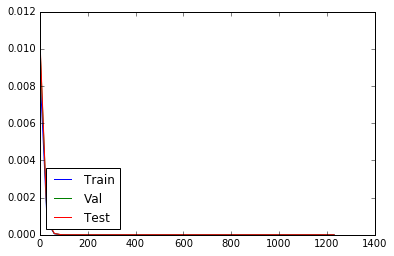

In [553]:
i = 0
plt.plot(Em.iteration[i:], Em.train_loss[i:])
plt.plot(Em.iteration[i:], Em.val_loss[i:])
plt.plot(Em.iteration[i:], Em.test_loss[i:])
plt.legend(['Train', 'Val', 'Test'], loc='lower left')


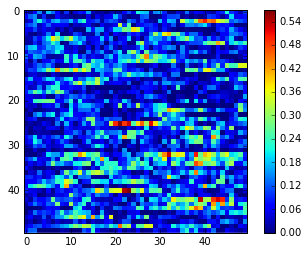

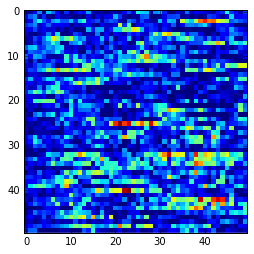

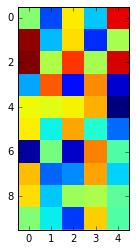

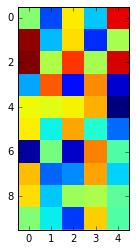

In [554]:
plt.imshow(Tm.predict([F1,F2])[:,:,0], interpolation='none')
# plt.clim([0, 0.01])
plt.colorbar()
plt.show()
plt.imshow(Em.predict([F1,F2])[:,:,0], interpolation='none')
# plt.clim([0, 0.01])
plt.show()

est_layers = Em.layer_vals()
true_layers = Tm.layer_vals()
# plt.imshow(true_layers[0]['W'][:,:,0])
# plt.show()
plt.imshow(est_layers[0][0]['W'][:,:,0], interpolation='none')
plt.show()
plt.imshow(true_layers[0][0]['W'][:,:,0], interpolation='none')
plt.show()



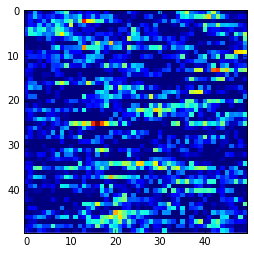

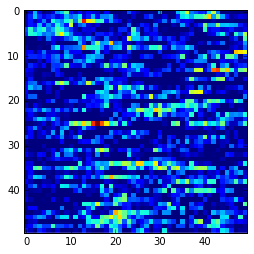

In [466]:
i = 0
predict_E = Em.nets[i].predict(F1, sess=Em.sess)
true_E = Tm.nets[i].predict(F1, sess=Em.sess)

plt.imshow(true_E[:,:,0], interpolation='none')
plt.show()
plt.imshow(predict_E[:,:,0], interpolation='none')
plt.show()

In [235]:
plt.clim?

In [159]:
est_layers

[[{'W': array([[[ 0.18498403,  0.11910194],
           [ 0.22476418,  0.30640784],
           [ 0.1159223 , -0.03854858],
           [ 0.20157583,  0.40052581],
           [-0.0383588 ,  0.49704796]],
   
          [[-0.08587682, -0.05879955],
           [ 0.09368144,  0.39256158],
           [ 0.09820986,  0.18957479],
           [ 0.24536802, -0.07744336],
           [ 0.16142328,  0.13678865]],
   
          [[ 0.41344306,  0.31638503],
           [ 0.14127865,  0.22141236],
           [ 0.35915211,  0.54855359],
           [-0.14094011, -0.16883264],
           [ 0.42438585,  0.02723134]],
   
          [[ 0.2813212 ,  0.10752684],
           [ 0.32810727,  0.32144195],
           [ 0.44775066,  0.51451492],
           [ 0.03566998,  0.28796884],
           [ 0.33355343, -0.09247782]],
   
          [[ 0.44640404, -0.02091191],
           [ 0.02142519,  0.05245899],
           [ 0.16047056,  0.24787962],
           [ 0.3657226 ,  0.40630567],
           [ 0.1055312 ,  0.57868743]],

In [1612]:
class Net:
    
    def __init__(self, data_dims, n_feats, sr_Hz, layers, weight_scale=0.1, seed=0, 
                 layers=['conv'], time_win_sec=1, actname='relu', 
                 n_kern=None, rank=None):
            
        # dimensionality of feature sand data
        self.n_stim = data_dims[0]
        self.n_tps_input = data_dims[1]
        self.n_resp = data_dims[2]
        self.n_feats = n_feats
        
        # place holders for input features and data
        self.F = tf.placeholder('float32', shape=[None, self.n_tps_input, self.n_feats])
        self.D = tf.placeholder('float32', shape=[None, self.n_tps_input, self.n_resp])
        
        # other parameters
        self.weight_scale = weight_scale
        self.seed = seed
        
        # layer parameters
        self.layers = layers
        self.n_layers = len(layers)
        self.actname = actname
        self.rank = rank
        self.time_win_smp = []
        for i in range(self.n_layers):
            self.time_win_smp.append(np.int32(np.round(sr_Hz*time_win_sec[i])))
        self.n_kern = n_kern
        if self.n_kern[self.n_layers-1] is None:
            self.n_kern[self.n_layers-1] = self.n_resp
        else:
            assert(self.n_kern[self.n_layers-1] == self.n_resp)
        
        # other misc parameters
        self.train_loss = []
        self.val_loss = []
        self.test_loss = []
        self.iteration = []
        self.learning_rate = tf.placeholder('float32')
        
    def initialize(self):
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        #self.saver = tf.train.Saver(max_to_keep=1)
        
    def build(self):
        
        self.W = []
        self.b = []
        self.L = []
        for i in range(self.n_layers):
            
            if i == 0:
                X = self.F
                n_input_feats = self.n_feats
                
            else:
                X = self.L[i-1]
                n_input_feats = self.n_kern[i-1]
            
            if self.layers[i]=='conv':
                self.W.append(kern2D(self.time_win_smp[i], n_input_feats, self.n_kern[i], 
                                     self.weight_scale, seed=self.seed, rank=self.rank[i]))
                self.b.append(kern2D(1, 1, self.n_kern[i], 
                                     self.weight_scale, seed=self.seed))
                self.L.append(act(self.actname[i])(conv1d(X, self.W[i]) + self.b[i]))
                
            elif self.layers[i]=='reweight':
                self.W.append(kern2D([1, n_input_feats, self.n_kern[i]],
                                     self.weight_scale, seed=self.seed))
                self.b.append([])
                self.L.append(act(self.actname[i])(X * self.W[i]))
                
            else:
                raise NameError('No matching layer type')
        
        # loss
        self.loss = tf.reduce_mean(tf.square(self.D - self.L[self.n_layers-1]))
        
        # gradient optimizer
        self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        # initialize global variables
        self.initialize()
        
    def train(self, F, D, learning_rate=0.5, n_iter=300, loss_interval=30, batch_size=None, train_val_test=np.zeros(D.shape[0])):
        
        with self.sess.as_default():
            
            # samples used for training, validation, and testing
            train_inds = np.where(train_val_test==0)[0]
            val_inds = np.where(train_val_test==1)[0]
            test_inds = np.where(train_val_test==2)[0]

            # dictionaries for validation and test
            # can initialize them now, because they are not batch dependent
            if True:
                val_dict = {self.F: F[val_inds, :, :], 
                            self.D: D[val_inds, :, :]}
            if len(test_inds)>0:
                test_dict = {self.F: F[test_inds, :, :], 
                             self.D: D[test_inds, :, :]}
                            
            # by default batch size equals the size of the training data
            if batch_size is None:
                batch_size = len(train_inds)
                
            # evaluate loss before any training
            if len(self.train_loss)==0:
                train_dict = {self.F: F[train_inds[np.arange(0, batch_size)], :, :], 
                              self.D: D[train_inds[np.arange(0, batch_size)], :, :], 
                              self.learning_rate: learning_rate}
                self.train_loss.append(self.loss.eval(feed_dict=train_dict))
                if len(val_inds)>0:
                    self.val_loss.append(self.loss.eval(feed_dict=val_dict))
                if len(test_inds)>0:
                    self.test_loss.append(self.loss.eval(feed_dict=test_dict))
                self.iteration = [0]
                
            # indices for this batch
            batch_inds = np.arange(0, batch_size)
            for i in range(n_iter):
                    
                # update
                train_dict = {self.F: F[train_inds[batch_inds], :, :], 
                             self.D: D[train_inds[batch_inds], :, :], 
                             self.learning_rate: learning_rate}
                self.train_step.run(feed_dict=train_dict)
                
                # evaluate loss
                if np.mod(i+1, loss_interval)==0:
                    print(i+1)
                    self.iteration.append(i+1)
                    self.train_loss.append(self.loss.eval(feed_dict=train_dict))
                    if len(val_inds)>0:
                        self.val_loss.append(self.loss.eval(feed_dict=val_dict))
                    if len(test_inds)>0:
                        self.test_loss.append(self.loss.eval(feed_dict=test_dict))
                
                # update batch
                batch_inds = np.mod(batch_inds + batch_size, len(train_inds))
                
    def predict(self, F):
        
        with self.sess.as_default():
            
            feed_dict = {self.F: F}
            return self.L[self.n_layers-1].eval(feed_dict=feed_dict)
        
    def params(self):
        
        with self.sess.as_default():
            
            W = []
            b = []
            for i in range(self.n_layers):
                W.append(self.W[i].eval())
                b.append(self.b[i].eval())
            
            return {'W': W, 'b': b}

In [1307]:
m.D.shape

TensorShape([Dimension(None), Dimension(100), Dimension(10)])

In [ ]:
temp_sr = 1000
temp_win = 1
temp_shifts = np.random.uniform(low=-1, high=1, size=(n_bases,))
temp_scales = np.random.uniform(low=-2, high=2, size=(n_bases,))
temp_rel_shifts = np.array([0, 1])
temp_rel_scales = np.array([0, 1])

spec_sr = 1000
spec_win = 1
spec_shifts = np.random.uniform(low=-1, high=1, size=(n_bases,))
spec_scales = np.random.uniform(low=-2, high=2, size=(n_bases,))
spec_rel_shifts = np.array([0, 1])
spec_rel_scales = np.array([0, 1])

n_trans = 2
n_bases = 10
spec_bases = np.zeros()
for j in range(n_trans):
    for i in range(n_bases):
        if j == 1 and i == 1:
            x = fn([sr, win, shifts[i], scales[i], rel_shifts[j], rel_scales[j]])['x']
        bases[:,i,j] = fn([sr, win, shifts[i], scales[i], rel_shifts[j], rel_scales[j]])['f']
        
        

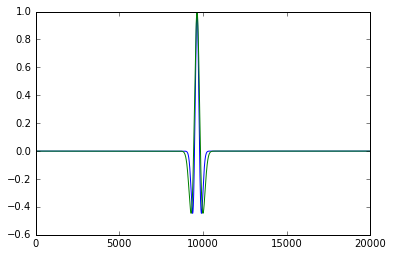

In [358]:
plt.plot(bases[:,3,0:2])

In [ ]:
weights = np.random.randn

In [ ]:
shifts = np.random.uniform

In [ ]:
shifts = np.random.uniform

In [86]:
win = 1
sr = 4
N = np.int32(np.round(sr * win))
x = np.linspace(-1, 1, N)*(0.5*(N-1)/N)*win
x

array([-0.375, -0.125,  0.125,  0.375])

In [34]:
np.linspace(0,0.8,5)

array([ 0. ,  0.2,  0.4,  0.6,  0.8])

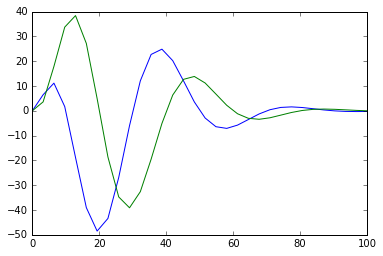

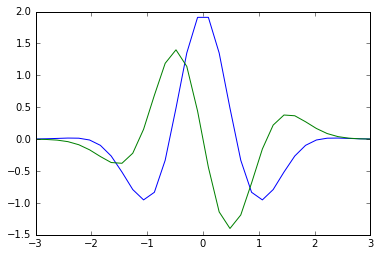

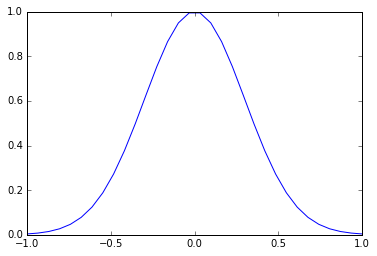

In [4]:
# based Hohmann, 2002, frequency analysis and synthesis using a gammatone filterbank, eq. 1
N = 32
sr_Hz = 0.01
t = np.linspace(0, 1, N) / sr_Hz
lbda = 0.9
B = np.pi*0.05
a = lbda * np.exp(1j*B)
gam = 3
htb = t**(gam-1) * a**t

plt.plot(t, np.real(htb))
plt.plot(t, np.imag(htb))
plt.show()

# based on matlab function cgauwavf
N = 32
sr_cycoct = 1
s = np.linspace(-3, 3, N) / sr_cycoct
s2 = np.square(s)
F0 = np.exp(-s2);
F1 = np.exp(-1j*s);
F2 = (F1*F0)/np.sqrt(np.exp(-1/2)*np.sqrt(2)*np.sqrt(np.pi));
hsb = -(1/3)*F2*(-3+4*1j*s+4*s2)*np.sqrt(6);

plt.plot(s, np.real(hsb))
plt.plot(s, np.imag(hsb))
plt.show()

N = 32
t = np.linspace(-1, 1, N)
sigma = 0.3
hl = np.exp(-np.square(t/sigma)/2)
plt.plot(t, hl)
plt.show()

In [ ]:
# class Net:
    
#     def __init__(self, data_dims, n_feats, sr_Hz, layers, weight_scale=0.1, seed=0, 
#                  layers=['conv'], time_win_sec=1, actname='relu', 
#                  n_kern=None, rank=None):
            
#         # dimensionality of feature sand data
#         self.n_stim = data_dims[0]
#         self.n_tps_input = data_dims[1]
#         self.n_resp = data_dims[2]
#         self.n_feats = n_feats
        
#         # place holders for input features and data
#         self.F = tf.placeholder('float32', shape=[None, self.n_tps_input, self.n_feats])
#         self.D = tf.placeholder('float32', shape=[None, self.n_tps_input, self.n_resp])
        
#         # other parameters
#         self.weight_scale = weight_scale
#         self.seed = seed
        
#         # layer parameters
#         self.layers = layers
#         self.n_layers = len(layers)
#         self.actname = actname
#         self.rank = rank
#         self.time_win_smp = []
#         for i in range(self.n_layers):
#             self.time_win_smp.append(np.int32(np.round(sr_Hz*time_win_sec[i])))
#         self.n_kern = n_kern
#         if self.n_kern[self.n_layers-1] is None:
#             self.n_kern[self.n_layers-1] = self.n_resp
#         else:
#             assert(self.n_kern[self.n_layers-1] == self.n_resp)
        
#         # other misc parameters
#         self.train_loss = []
#         self.val_loss = []
#         self.test_loss = []
#         self.iteration = []
#         self.learning_rate = tf.placeholder('float32')
        
#     def initialize(self):
        
#         self.sess = tf.Session()
#         self.sess.run(tf.global_variables_initializer())
#         #self.saver = tf.train.Saver(max_to_keep=1)
        
#     def build(self):
        
#         self.W = []
#         self.b = []
#         self.L = []
#         for i in range(self.n_layers):
            
#             if i == 0:
#                 X = self.F
#                 n_input_feats = self.n_feats
                
#             else:
#                 X = self.L[i-1]
#                 n_input_feats = self.n_kern[i-1]
            
#             if self.layers[i]=='conv':
#                 self.W.append(kern2D(self.time_win_smp[i], n_input_feats, self.n_kern[i], 
#                                      self.weight_scale, seed=self.seed, rank=self.rank[i]))
#                 self.b.append(kern2D(1, 1, self.n_kern[i], 
#                                      self.weight_scale, seed=self.seed))
#                 self.L.append(act(self.actname[i])(conv1d(X, self.W[i]) + self.b[i]))
                
#             elif self.layers[i]=='reweight':
#                 self.W.append(kern2D([1, n_input_feats, self.n_kern[i]],
#                                      self.weight_scale, seed=self.seed))
#                 self.b.append([])
#                 self.L.append(act(self.actname[i])(X * self.W[i]))
                
#             else:
#                 raise NameError('No matching layer type')
        
#         # loss
#         self.loss = tf.reduce_mean(tf.square(self.D - self.L[self.n_layers-1]))
        
#         # gradient optimizer
#         self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

#         # initialize global variables
#         self.initialize()
        
#     def train(self, F, D, learning_rate=0.5, n_iter=300, loss_interval=30, batch_size=None, train_val_test=np.zeros(D.shape[0])):
        
#         with self.sess.as_default():
            
#             # samples used for training, validation, and testing
#             train_inds = np.where(train_val_test==0)[0]
#             val_inds = np.where(train_val_test==1)[0]
#             test_inds = np.where(train_val_test==2)[0]

#             # dictionaries for validation and test
#             # can initialize them now, because they are not batch dependent
#             if True:
#                 val_dict = {self.F: F[val_inds, :, :], 
#                             self.D: D[val_inds, :, :]}
#             if len(test_inds)>0:
#                 test_dict = {self.F: F[test_inds, :, :], 
#                              self.D: D[test_inds, :, :]}
                            
#             # by default batch size equals the size of the training data
#             if batch_size is None:
#                 batch_size = len(train_inds)
                
#             # evaluate loss before any training
#             if len(self.train_loss)==0:
#                 train_dict = {self.F: F[train_inds[np.arange(0, batch_size)], :, :], 
#                               self.D: D[train_inds[np.arange(0, batch_size)], :, :], 
#                               self.learning_rate: learning_rate}
#                 self.train_loss.append(self.loss.eval(feed_dict=train_dict))
#                 if len(val_inds)>0:
#                     self.val_loss.append(self.loss.eval(feed_dict=val_dict))
#                 if len(test_inds)>0:
#                     self.test_loss.append(self.loss.eval(feed_dict=test_dict))
#                 self.iteration = [0]
                
#             # indices for this batch
#             batch_inds = np.arange(0, batch_size)
#             for i in range(n_iter):
                    
#                 # update
#                 train_dict = {self.F: F[train_inds[batch_inds], :, :], 
#                              self.D: D[train_inds[batch_inds], :, :], 
#                              self.learning_rate: learning_rate}
#                 self.train_step.run(feed_dict=train_dict)
                
#                 # evaluate loss
#                 if np.mod(i+1, loss_interval)==0:
#                     print(i+1)
#                     self.iteration.append(i+1)
#                     self.train_loss.append(self.loss.eval(feed_dict=train_dict))
#                     if len(val_inds)>0:
#                         self.val_loss.append(self.loss.eval(feed_dict=val_dict))
#                     if len(test_inds)>0:
#                         self.test_loss.append(self.loss.eval(feed_dict=test_dict))
                
#                 # update batch
#                 batch_inds = np.mod(batch_inds + batch_size, len(train_inds))
                
#     def predict(self, F):
        
#         with self.sess.as_default():
            
#             feed_dict = {self.F: F}
#             return self.L[self.n_layers-1].eval(feed_dict=feed_dict)
        
#     def params(self):
        
#         with self.sess.as_default():
            
#             W = []
#             b = []
#             for i in range(self.n_layers):
#                 W.append(self.W[i].eval())
#                 b.append(self.b[i].eval())
            
#             return {'W': W, 'b': b}